In [2]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv -o
%load_ext nb_black

<IPython.core.display.Javascript object>

In [1]:
import json
from pathlib import Path
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = "notebook"
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.express as px
from matchms import Spectrum, calculate_scores
from matchms.filtering import default_filters, normalize_intensities, square_root_intensities
from matchms.similarity.vector_similarity_functions import cosine_similarity_matrix
from matchms.similarity import ModifiedCosine
from matchms.networking import SimilarityNetwork
#from matchms_plotly import  plot_spectra
from retrorules_gdr_2021.data import ExperimentalData

In [2]:
mgf_path = "/home/yann/Cloud/Pro/Projets/MetWork/Data/Sideritis/mgf_réseau_7fractions_Irlande.mgf"
exp_data = ExperimentalData(mgf_path)

In [3]:
spectra = [
    square_root_intensities(
        normalize_intensities(
            default_filters(
                spectrum)))
    for spectrum in exp_data.spectra]

In [33]:

modified_cosine = ModifiedCosine(tolerance=0.02)
scores = calculate_scores(spectra, spectra, modified_cosine)
# ms_network = SimilarityNetwork(identifier_key="testID")
# ms_network.create_network(scores)


In [34]:
np.sum(scores.scores["score"])

3240.1469190964917

In [35]:
scores_ = scores.scores.copy()
scores_["score"] = np.where(scores_["matches"]<6, 0, scores_["score"])
scores_["matches"] = np.where(scores_["matches"]<6, 0, scores_["matches"])
np.sum(scores_["score"])

888.6700862531984

In [36]:

scores._scores = scores_
np.sum(scores.scores["score"])

888.6700862531984

In [37]:
input_scans =["175","168","191","190"]
scans = ["175","168","191","190","152",
    "173",
    "182",
    "186",
    "194",
]
#scans = [int(scan) for scan in scans]
selected_scans = np.isin(exp_data.metadata.scans, scans)

In [38]:
ms_network = SimilarityNetwork(
    identifier_key="scans",
    link_method="mutual", 
    score_cutoff=0.7,
    top_n=5,
    max_links=5)
ms_network.create_network(scores)

In [65]:
for sub in nx.connected_components(ms_network.graph):
    if "175" in sub:
        subgraph = nx.subgraph(ms_network.graph,sub)

In [72]:
subspectra = spectra = [
    square_root_intensities(
        normalize_intensities(
            default_filters(
                spectrum)))
    for spectrum in exp_data.spectra
    if spectrum.metadata["scans"] in subgraph.nodes()]
subscores = calculate_scores(spectra, spectra, modified_cosine)

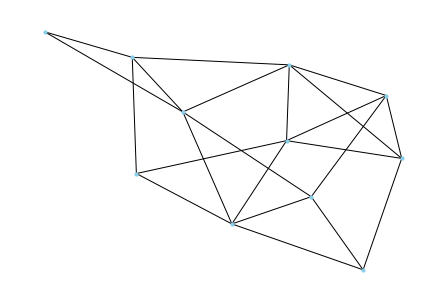

In [99]:
G = subgraph

layout = nx.spring_layout(G)

init = np.array([
    (x,y) for _,x,y in sorted(
        (int(key), *value)
        for key, value in layout.items())
])

pos=layout
nx.draw(G, with_labels=False, node_size=10, node_color="skyblue", pos=pos)

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 11 samples in 0.000s...
[t-SNE] Computed neighbors for 11 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 11 / 11
[t-SNE] Mean sigma: 0.089701
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.783272


/home/yann/miniconda3/envs/retrorules_gdr_2021/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



[t-SNE] KL divergence after 5650 iterations: 0.452245


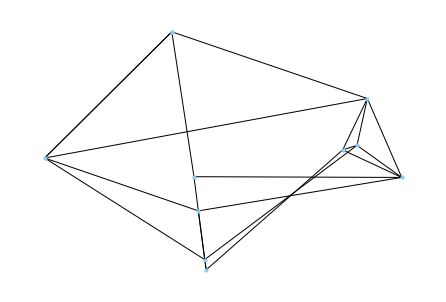

In [149]:
# tsne = TSNE(n_components=2, learning_rate='auto', init='random')
score_matrix_tsne = subscores.scores["score"]
score_matrix_tsne = np.where(subscores.scores["matches"]<6, 0, score_matrix_tsne)
score_matrix_tsne = np.where(score_matrix_tsne<0.7, 0, score_matrix_tsne)
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=20000, learning_rate='auto', init=init)
# tsne = TSNE(n_components=2, verbose=1, perplexity=0.001, n_iter=10000, learning_rate=0.001, init=init)
tsne = TSNE(n_components=2, verbose=1, n_iter=10000, perplexity=1, learning_rate=0.00001, init="pca")

tsne_results = tsne.fit_transform(score_matrix_tsne)

pos = {subspectra[key].metadata["scans"]: values for key, values in enumerate(tsne_results)}
nx.draw(subgraph, with_labels=False, node_size=10, node_color="skyblue", pos=pos)

#fig = px.scatter(x=tsne_results[:,0], y=tsne_results[:,1], color=selected_scans)
#fig.show()

In [150]:
# positions = init*600
# positions = tsne_results*40
# this function is used to convert networkx to Cytoscape.js JSON format
# returns string of JSON
def convert2cytoscapeJSON(G):
    # load all nodes into nodes array
    final = []
    for node in G.nodes():
        nx = {}
        nx["data"] = {}
        nx["data"]["id"] = node
        index = int(node) - 1
        nx["data"]["label"] = f"{node} - {str(round(exp_data.metadata.pepmass[index],3))}"
        if node in input_scans:
            color = "green"
        elif node in scans:
            color = "orange"
        else:
            color = "grey"
        nx["data"]["color"]= color
        # nx["data"]["label"] = str(round(exp_data.metadata.pepmass[index],3))
        nx["position"] = {
            "x": pos[node][0]*100,
            "y": pos[node][1]*100}
            # "x": int(positions[index,0]),
            # "y": int(positions[index,1])}
        final.append(nx.copy())
    #load all edges to edges array
    for edge in G.edges():
    # for edge in netw:
        if edge[0] != edge[1]:
            nx = {}
            nx["data"]={}
            nx["data"]["id"]=f"{edge[0]}-{edge[1]}"
            nx["data"]["source"]=edge[0]
            nx["data"]["target"]=edge[1]
            #cosine = edge[3]
            cosine = scores.scores["score"][int(edge[0])-1][int(edge[1])-1]
            matches = scores.scores["matches"][int(edge[0])-1][int(edge[1])-1]
            nx["data"]["label"] = f"{round(cosine, 2)} - {matches}"
            #nx["data"]["label"] = str(round(cosine, 2))
            nx["data"]["opacity"] = pow(cosine, 2)
            final.append(nx)
    return final

cytoscape_data = convert2cytoscapeJSON(subgraph)
Path("data", "network-tsne.json").write_text(json.dumps(cytoscape_data))

4001

In [58]:
1/np.sqrt(len(init))

0.06804138174397717

In [101]:
fig = px.scatter(x=tsne_results[:,0], y=tsne_results[:,1], color=colors)
fig.show()

NameError: name 'colors' is not defined

In [321]:
selected_spectra = [sp for selected, sp in zip(selected_scans, spectra) if selected]
selected_spectra

In [67]:
exp_data.metadata.scans

0        1
1        2
2        3
3        4
4        5
      ... 
211    212
212    213
213    214
214    215
215    216
Name: scans, Length: 216, dtype: object

In [85]:
exp_data.metadata

pepmass charge mslevel precursorintensity         filename  \
0    158.96300   [0+]       2      729081.375000  specs_ms.pklbin   
1    160.09599   [1+]       2    35741676.000000  specs_ms.pklbin   
2    167.01199   [0+]       2     1151948.500000  specs_ms.pklbin   
3    172.97600   [0+]       2     2481079.250000  specs_ms.pklbin   
4    182.98399   [0+]       2      856016.187500  specs_ms.pklbin   
..         ...    ...     ...                ...              ...   
211  919.59302   [1+]       2     1042359.062500  specs_ms.pklbin   
212  923.52802   [1+]       2      846676.250000  specs_ms.pklbin   
213  937.58398   [1+]       2      821215.000000  specs_ms.pklbin   
214  953.58002   [1+]       2     1477116.500000  specs_ms.pklbin   
215  959.56897   [1+]       2     1465303.875000  specs_ms.pklbin   

     rtinseconds activation instrument             title scans  
0    1673.699951        CID   ion trap    Scan Number: 1     1  
1     102.169998        CID   ion trap    Scan Number: 2     2  
2    1156.290039        CID   ion trap    Scan Number: 3     3  
3     123.747002        CID   ion trap    Scan Number: 4     4  
4    1326.119995        CID   ion trap    Scan Number: 5     5  
..           ...        ...        ...               ...   ...  
211  2043.119995        CID   ion trap  Scan Number: 212   212  
212  1874.060059        CID   ion trap  Scan Number: 213   213  
213  1819.650024        CID   ion trap  Scan Number: 214   214  
214  1642.900024        CID   ion trap  Scan Number: 215   215  
215  1693.089966        CID   ion trap  Scan Number: 216   216  

[216 rows x 10 columns]

In [47]:
ms_network.graph

In [102]:
x, y = list(ms_network.graph.edges())[0]
score_matrix[int(x)-1][int(y)-1]


0.7237673857593493

In [142]:
score_matrix[145][193]

0.9115988802039862

In [140]:
edge = list(ms_network.graph.edges())[0]
edge

('14', '12')

In [143]:
score_matrix[int(edge[0])+1][int(edge[0])+1]

1.0000000000000002

In [114]:
spectra[145].metadata

{'pepmass': (595.50403, None),
 'charge': 1,
 'mslevel': '2',
 'precursorintensity': '656635.812500',
 'filename': 'specs_ms.pklbin',
 'rtinseconds': 2105.850098 second,
 'activation': 'CID',
 'instrument': 'ion trap',
 'title': 'Scan Number: 146',
 'scans': '146',
 'ionmode': 'n/a',
 'compound_name': 'Scan Number: 146',
 'precursor_mz': 595.50403}

In [113]:
modified_cosine.pair(spectra[145], spectra[193])

array((0.91159888, 6), dtype=[('score', '<f8'), ('matches', '<i8')])

In [19]:
fig = px.scatter(x=tsne_results[:,0], y=tsne_results[:,1], color=colors)
fig.show()

In [9]:
exp_data.metadata

pepmass charge mslevel precursorintensity         filename  \
0    158.96300   [0+]       2      729081.375000  specs_ms.pklbin   
1    160.09599   [1+]       2    35741676.000000  specs_ms.pklbin   
2    167.01199   [0+]       2     1151948.500000  specs_ms.pklbin   
3    172.97600   [0+]       2     2481079.250000  specs_ms.pklbin   
4    182.98399   [0+]       2      856016.187500  specs_ms.pklbin   
..         ...    ...     ...                ...              ...   
211  919.59302   [1+]       2     1042359.062500  specs_ms.pklbin   
212  923.52802   [1+]       2      846676.250000  specs_ms.pklbin   
213  937.58398   [1+]       2      821215.000000  specs_ms.pklbin   
214  953.58002   [1+]       2     1477116.500000  specs_ms.pklbin   
215  959.56897   [1+]       2     1465303.875000  specs_ms.pklbin   

     rtinseconds activation instrument             title scans  
0    1673.699951        CID   ion trap    Scan Number: 1     1  
1     102.169998        CID   ion trap    Scan Number: 2     2  
2    1156.290039        CID   ion trap    Scan Number: 3     3  
3     123.747002        CID   ion trap    Scan Number: 4     4  
4    1326.119995        CID   ion trap    Scan Number: 5     5  
..           ...        ...        ...               ...   ...  
211  2043.119995        CID   ion trap  Scan Number: 212   212  
212  1874.060059        CID   ion trap  Scan Number: 213   213  
213  1819.650024        CID   ion trap  Scan Number: 214   214  
214  1642.900024        CID   ion trap  Scan Number: 215   215  
215  1693.089966        CID   ion trap  Scan Number: 216   216  

[216 rows x 10 columns]

In [171]:
all_mz = np.concatenate([spectrum.peaks.mz for spectrum in exp_data.spectra])

In [172]:
np.min(all_mz)

50.396

In [173]:
np.max(all_mz)

1956.484009

In [197]:
diff = np.sort(np.diff(np.sort(all_mz)))
diff[np.where(diff>0)]

array([9.7600000e-04, 9.7600000e-04, 9.7600000e-04, ..., 6.8259033e+01,
       7.6925049e+01, 7.7210937e+01])

In [203]:
np.arange(50, 2000,0.001)

array([  50.   ,   50.001,   50.002, ..., 1999.997, 1999.998, 1999.999])

In [206]:
mz = exp_data.spectra[0].peaks.mz
np.digitize(mz, np.arange(50, 2000, 1e-5))

array([1497700, 1849300, 1975701, 2582801, 3587500, 4097600, 8625200,
       8681301])

In [98]:
digits = [np.digitize(sp.peaks.mz, np.arange(50, 2000, 5*1e-6)) for sp in spectra]


KeyboardInterrupt: 

In [ ]:
#spectra_ = [normalize_intensities(sp) for sp in spectra]
df = pd.concat(
    [pd.DataFrame(
        {bin: intensity for bin, intensity in zip(digits[index],np.sqrt(sp.peaks.intensities))},
        index=[index])
    for index, sp in enumerate(spectra)
    ])

In [93]:
values_concat = np.concatenate([score_matrix, df.fillna(0).values], axis=1)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, learning_rate='auto', init='pca', n_iter = 20000)
#tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(df.fillna(0).values)


In [ ]:
fig = px.scatter(x=tsne_results[:,0], y=tsne_results[:,1], color=selected_scans)
fig.show()

In [250]:
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
      

In [4]:
[
    "[H]Oc1c([H])c([H])c([H])c(-c2oc3c(O[H])c(OC4([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C4([H])OC4([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C4([H])O[H])c([H])c(O[H])c3c(=O)c2[H])c1[H]",
    "[H]Oc1c([H])c([H])c(-c2oc3c(O[H])c(OC4([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C4([H])OC4([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C4([H])O[H])c([H])c(O[H])c3c(=O)c2[H])c([H])c1[H]",
    "[H]Oc1c(OC2([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C2([H])OC2([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C2([H])O[H])c([H])c(O[H])c2c(=O)c([H])c(-c3c([H])c([H])c(OC([H])([H])[H])c([H])c3[H])oc12",
    "[H]Oc1c([H])c([H])c(-c2oc3c(O[H])c(OC4([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C4([H])OC4([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C4([H])O[H])c([H])c(O[H])c3c(=O)c2[H])c([H])c1O[H]",
    "[H]Oc1c(OC2([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C2([H])OC2([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C2([H])O[H])c([H])c(O[H])c2c(=O)c([H])c(-c3c([H])c([H])c(OC([H])([H])[H])c([H])c3[H])oc12",
    "[H]Oc1c([H])c([H])c(-c2oc3c(O[H])c(OC4([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C4([H])OC4([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C4([H])O[H])c([H])c(O[H])c3c(=O)c2[H])c([H])c1[H]",
    "[H]Oc1c([H])c(-c2oc3c(O[H])c(OC4([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C4([H])OC4([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C4([H])O[H])c([H])c(O[H])c3c(=O)c2[H])c([H])c([H])c1OC([H])([H])[H]",
    "[H]Oc1c([H])c(-c2oc3c(O[H])c(OC4([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C4([H])OC4([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C4([H])O[H])c([H])c(O[H])c3c(=O)c2[H])c([H])c([H])c1OC([H])([H])[H]",
    "[H]Oc1c([H])c([H])c(-c2oc3c(O[H])c(OC4([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C4([H])OC4([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C4([H])O[H])c([H])c(O[H])c3c(=O)c2[H])c([H])c1OC([H])([H])[H]",
    "[H]Oc1c([H])c([H])c(-c2oc3c(O[H])c(OC4([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C4([H])OC4([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C4([H])O[H])c([H])c(O[H])c3c(=O)c2[H])c([H])c1OC([H])([H])[H]",
    "[H]Oc1c([H])c([H])c(-c2oc3c(O[H])c(OC4([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C4([H])O[H])c([H])c(O[H])c3c(=O)c2[H])c([H])c1[H]",
]

['[H]Oc1c([H])c([H])c([H])c(-c2oc3c(O[H])c(OC4([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C4([H])OC4([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C4([H])O[H])c([H])c(O[H])c3c(=O)c2[H])c1[H]',
 '[H]Oc1c([H])c([H])c(-c2oc3c(O[H])c(OC4([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C4([H])OC4([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C4([H])O[H])c([H])c(O[H])c3c(=O)c2[H])c([H])c1[H]',
 '[H]Oc1c(OC2([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C2([H])OC2([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C2([H])O[H])c([H])c(O[H])c2c(=O)c([H])c(-c3c([H])c([H])c(OC([H])([H])[H])c([H])c3[H])oc12',
 '[H]Oc1c([H])c([H])c(-c2oc3c(O[H])c(OC4([H])OC([H])(C([H])([H])OC(=O)C([H])([H])[H])C([H])(O[H])C([H])(O[H])C4([H])OC4([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C4([H])O[H])c([H])c(O[H])c3c(=O)c2[H])c([H])c1O[H]',
 '[H]Oc1c(OC2([H])OC([H])(C([H])([H])O[H])C([H])(O[H])C([H])(O[H])C2([H])OC2([H])OC([H])(C([H])([H])OC(=O)

<IPython.core.display.Javascript object>